Notes in the following documents:
1. https://courses.cs.washington.edu/courses/cse576/17sp/notes/CamerasStereo17.pdf
2. https://www.cs.cmu.edu/~16385/s17/Slides/13.1_Stereo_Rectification.pdf


In [142]:
import numpy as np
import cv2 as cv
import sys
import os
from pathlib import Path
from typing import Dict, Tuple
from numpy.testing import assert_allclose, assert_almost_equal
from matplotlib import pyplot as plt
import torch
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
print(cv.__version__)
image_shape = (752, 480)
IMG_PATH = "/media/jagatpreet/D/datasets/euroc/MH_01_easy/mav0"

4.5.5


In [143]:
def euroc_stereo_cam_configuration() -> Tuple[Dict, Dict]:
    """
    Defines the stereo cam configuration of EUROC setup.
    """

    
    # instrinsic parameters
    K_l = np.array([[458.654, 0.0, 367.215], 
                    [0.0, 457.296, 248.375], 
                    [0.0, 0.0, 1.0],
    ])

    K_r = np.array([[457.587, 0.0, 379.999],
                    [0.0, 456.134, 255.238],
                    [0.0, 0.0, 1]
    ])
    # transformations 
    T_B_C0 = np.array([
        [0.0148655429818, -0.999880929698, 0.00414029679422, -0.0216401454975],
        [0.999557249008, 0.0149672133247, 0.025715529948, -0.064676986768],
        [-0.0257744366974, 0.00375618835797, 0.999660727178, 0.00981073058949],
        [ 0.0, 0.0, 0.0, 1.0]
    ])

    T_B_C1 = np.array([
        [0.0125552670891, -0.999755099723, 0.0182237714554, -0.0198435579556],
        [0.999598781151, 0.0130119051815, 0.0251588363115, 0.0453689425024],
        [-0.0253898008918, 0.0179005838253, 0.999517347078, 0.00786212447038],
        [0.0, 0.0, 0.0, 1.0]
    ])

    # Rotation parameters
    R_l = np.array([
         [0.999966347530033, -0.001422739138722922, 0.008079580483432283], 
         [0.001365741834644127, 0.9999741760894847, 0.007055629199258132], 
        [-0.008089410156878961, -0.007044357138835809, 0.9999424675829176],
    ])

    R_r = np.array([
         [0.9999633526194376, -0.003625811871560086, 0.007755443660172947], 
         [0.003680398547259526, 0.9999684752771629, -0.007035845251224894], 
        [-0.007729688520722713, 0.007064130529506649, 0.999945173484644],
    ])

    # distortion parameter
    # 
    d_l = np.array([-0.28340811, 0.07395907, 0.00019359, 1.76187114e-05, 0.0])
    d_r = np.array([-0.28368365, 0.07451284, -0.00010473, -3.555907e-05, 0.0])

    # Projection
    P_l = np.array([[435.2046959714599, 0, 367.4517211914062, 0],  
                    [0, 435.2046959714599, 252.2008514404297, 0],  
                    [0, 0, 1, 0]
    ])

    P_r = np.array([[435.2046959714599, 0, 367.4517211914062, -47.90639384423901],
                    [ 0, 435.2046959714599, 252.2008514404297, 0], 
                    [0, 0, 1, 0]])
    cam_L = {'T' : T_B_C0, 'k': K_l, 'd': d_l, 'R': R_l, 'P': P_l}
    cam_R = {'T' : T_B_C1, 'k': K_r, 'd': d_r, 'R': R_r, 'P': P_r}
    return cam_L, cam_R

def rectification_map(cam_L:Dict, cam_R: Dict, image_shape) -> Tuple[np.ndarray, np.ndarray]:
    """
    """
    map_l = cv.initUndistortRectifyMap(cam_L['k'], cam_L['d'], cam_L['R'], cam_L['P'], image_shape, cv.CV_32F)
    map_r = cv.initUndistortRectifyMap(cam_R['k'], cam_R['d'], cam_R['R'], cam_R['P'], image_shape, cv.CV_32F)
    print(f"Shape of undistort map in stereo camera: {map_l.shape}")
    return map_l, map_r 

In [144]:
cam_l, cam_r = euroc_stereo_cam_configuration()
print("\nLeft camera\n")
for k in cam_l.keys():
    print(f'{k} = \n {cam_l[k]}')

print("\nRight camera \n")
for k in cam_r.keys():
    print(f'{k} = \n {cam_r[k]}')



Left camera

T = 
 [[ 0.0149 -0.9999  0.0041 -0.0216]
 [ 0.9996  0.015   0.0257 -0.0647]
 [-0.0258  0.0038  0.9997  0.0098]
 [ 0.      0.      0.      1.    ]]
k = 
 [[458.654   0.    367.215]
 [  0.    457.296 248.375]
 [  0.      0.      1.   ]]
d = 
 [-0.2834  0.074   0.0002  0.      0.    ]
R = 
 [[ 1.     -0.0014  0.0081]
 [ 0.0014  1.      0.0071]
 [-0.0081 -0.007   0.9999]]
P = 
 [[435.2047   0.     367.4517   0.    ]
 [  0.     435.2047 252.2009   0.    ]
 [  0.       0.       1.       0.    ]]

Right camera 

T = 
 [[ 0.0126 -0.9998  0.0182 -0.0198]
 [ 0.9996  0.013   0.0252  0.0454]
 [-0.0254  0.0179  0.9995  0.0079]
 [ 0.      0.      0.      1.    ]]
k = 
 [[457.587   0.    379.999]
 [  0.    456.134 255.238]
 [  0.      0.      1.   ]]
d = 
 [-0.2837  0.0745 -0.0001 -0.      0.    ]
R = 
 [[ 1.     -0.0036  0.0078]
 [ 0.0037  1.     -0.007 ]
 [-0.0077  0.0071  0.9999]]
P = 
 [[435.2047   0.     367.4517 -47.9064]
 [  0.     435.2047 252.2009   0.    ]
 [  0.       0.     

In [145]:
R = cam_l['R'].T @ cam_r['R']
T_lr = np.linalg.inv(cam_l['T']) @ cam_r['T'] 
# The translation vector is in the frame of left camera.
# so the left camera is relatively an identity matrix here.
t_lr = T_lr[:3, 3]
R_lr = T_lr[:3, :3]

print(f'Transformation matrix right wrt left : \n { T_lr}')
print(f'Rotation matrix matrix right wrt left : \n { T_lr[:3, :3]}, \n Translation between two cameras: \n {t_lr.transpose()}')
print(f'Rotation matrix R : \n {R}')
print(f'How close are the rotation matrix: \n{np.allclose(R, T_lr[:3, :3])}')

Transformation matrix right wrt left : 
 [[ 1.     -0.0023 -0.0003  0.1101]
 [ 0.0023  0.9999 -0.0141 -0.0002]
 [ 0.0004  0.0141  0.9999  0.0009]
 [ 0.      0.      0.      1.    ]]
Rotation matrix matrix right wrt left : 
 [[ 1.     -0.0023 -0.0003]
 [ 0.0023  0.9999 -0.0141]
 [ 0.0004  0.0141  0.9999]], 
 Translation between two cameras: 
 [ 0.1101 -0.0002  0.0009]
Rotation matrix R : 
 [[ 1.     -0.0023 -0.0003]
 [ 0.0023  0.9999 -0.0141]
 [ 0.0004  0.0141  0.9999]]
How close are the rotation matrix: 
True


In [146]:
# this matrix represents the perspective transform 
# many to one mapping - converting points along a ray to point on 2D plane.
projection = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0]]
)
P_l = cam_l['k'] @ projection @ np.eye(4)
P_r = cam_r['k'] @ projection @ T_lr
print(f'Projection matrices - \n Left camera = \n {P_l} \n\n right camera: \n {P_r}')


Projection matrices - 
 Left camera = 
 [[458.654   0.    367.215   0.   ]
 [  0.    457.296 248.375   0.   ]
 [  0.      0.      1.      0.   ]] 

 right camera: 
 [[457.7286   4.2938 379.8041  50.7065]
 [  1.1506 459.6838 248.7854   0.1556]
 [  0.0004   0.0141   0.9999   0.0009]]


# Epipolar geometry
1. Baseline : Line connecting the two camera centers - camera center is not the optical center. 
2. Epipoles : intersections of baseline with image planes - gives two epipoles.
3. Epipolar plane: plane containing baseline
4. Epipolar lines: intersection of epipolar plane with image planes.
5. When motion is parallel to image plane - no rotational motion between two image planes, baseline is parallel to the image planes as well. So the epipoles are at infinity. 
6. The epipolar plane family intersects the image plane at same heights.
7. Idea: Can we find another plane for a pair of cameras where we can project the image and the images in that plane appear to move parallel.
For such a plane, the epipoles are at infinity. And all the points in left image have a correspondence for the right image at same y coordinate of image.
8. Image plane L, Image plane R and Image plane rectified are the planes of interest. 
We need to find a homography for $H_L$ and $H_R$ to get the all image points to rectified plane.



We already have the Rotation and translation of the stereo camera given to us.
So we have not calculated the Essential matrix by matching points and then recovered pose from it.
We need to form the rectification matrix R_rect
https://www.cs.cmu.edu/~16385/s17/Slides/13.1_Stereo_Rectification.pdf

Get the epipole. Epipole is along the line joining the optical centers.
Direction of epipole is given this vector.

Note: The rectification matrix transforms the epipole to a point at infinity. There are many possibilities for such a transformation but we are trying to find a 
transformation that causes minimal distortion.

In [147]:

e = t_lr/np.linalg.norm(t_lr)
# direction vector of optical axis
# Now we are in the camera frame
z_l = np.array([0, 0, 1])
# Finding three mutually perpendicular axis to get the R_rect
# epipole direction of first camera
r1 = e
r2 = np.cross(z_l, r1)
r3 = np.cross(r1, r2)
# we got l_R_rect by stacking columnwise
R_rect = np.stack((r1, r2, r3), axis = 1)
# In opencv, camera 2 is the left camera frame for a stereo setup based on stereocalibrate function,
# they are referring as the first and second camera frame.Here we are referring as the left and right camera. 
# https://stackoverflow.com/questions/61039285/what-camera-is-chosen-as-the-origin-in-cv2-stereocalibrate

# transform the left camera points to the rectified frame
# we need rect_Rot_l 
R_l = R_rect.T


# we need rect_Rot_r = rect_rot_l * l_rot_r
# transforrm the right camera frame to the rectified frame
R_r = R_rect.T @ R
print(f'Rotation matrices : \n R_l = \n {R_l} \n\n R_r = \n {R_r}')
P_l = cam_l['k']@ projection @ np.block([[R_l, np.zeros([3, 1])],
                                         [np.zeros([1, 3]), 1]])
t_lr = t_lr.reshape(3, 1)
# The 3D point is in the frame of Left camera and is seen in the right camera frame.
# Now after rectification the camera frames are parallel. So, the 3D point has to be converted 
# into the rectification frame.
# To convert it into the right camera frame we express the left rectified camera axis
# in the right camera frame. therefore -t_lr.
P_r = cam_r['k']@ projection @ np.block([[R_r@R_lr.T, -t_lr.reshape(3, 1)],
                                         [np.zeros([1, 3]), 1]])
print(f'\n projective matrices computed \n\n left camera = \n {P_l} \n\n right camera = \n {P_r}')

Rotation matrices : 
 R_l = 
 [[ 1.     -0.0014  0.0081]
 [ 0.0014  1.     -0.    ]
 [-0.0081  0.      0.9999]] 

 R_r = 
 [[ 1.     -0.0036  0.0078]
 [ 0.0037  0.9999 -0.0141]
 [-0.0077  0.0141  0.9998]]

 projective matrices computed 

 left camera = 
 [[455.6717  -0.6483 370.8968   0.    ]
 [ -1.3561 457.2835 248.3588   0.    ]
 [ -0.0081   0.       0.9999   0.    ]] 

 right camera = 
 [[454.5015  -0.6467 383.6713 -50.7065]
 [ -1.4132 456.1216 255.2213  -0.1556]
 [ -0.0081   0.       0.9999  -0.0009]]


In [148]:
# to satisfy the convention of opencv
# left is camera 1 , right is camera 2
# opencv documentation says - rotation of first camera wrt  second camera. which is R_21
R = R_lr.T # opencv needs rotation of right camera wrt left camera. 
t = -t_lr  # opencv needs translation left camera from right camera.

# camera 1 - opencv left camera
k1 = cam_r['k']
d1 = cam_r['d']

# camera 2 - opencv right camera camera
k2 = cam_l['k']
d2 = cam_l['d']

output = cv.stereoRectify(k1, d1, k2, d2 , image_shape, R, t )
print('Output from cv function')
name = ['R1 - left camera', 'R2 - right camera', 'P1 - left ', 'P2 -right ', 'Q']

for n, o in zip(name, output):
    print(f' \n {n} : \n{o}')
R_l = output[0]
R_r = output[1]
P_l = output[2]
P_r = output[3]

Output from cv function
 
 R1 - left camera : 
[[ 1.      0.0008  0.0084]
 [-0.0008  1.      0.007 ]
 [-0.0084 -0.0071  0.9999]]
 
 R2 - right camera : 
[[ 1.     -0.0014  0.0081]
 [ 0.0015  1.     -0.007 ]
 [-0.0081  0.0071  0.9999]]
 
 P1 - left  : 
[[456.715    0.     364.1422   0.    ]
 [  0.     456.715  256.9431   0.    ]
 [  0.       0.       1.       0.    ]]
 
 P2 -right  : 
[[456.715    0.     364.1422 -50.2742]
 [  0.     456.715  256.9431   0.    ]
 [  0.       0.       1.       0.    ]]
 
 Q : 
[[   1.        0.        0.     -364.1422]
 [   0.        1.        0.     -256.9431]
 [   0.        0.        0.      456.715 ]
 [   0.        0.        9.0845   -0.    ]]


In [149]:

print(f"projective matrices euroc \n\n left camera = \n {cam_l['P']} \n\n right camera = \n {cam_r['P']}")
#print(f"How close is computed vs given?  \n\n left camera = \n {np.allclose(cam_l['P'][:3, :3], P_l)} \n\n right camera = \n {np.allclose(cam_r['P'][:3, :3], P_r)}")

projective matrices euroc 

 left camera = 
 [[435.2047   0.     367.4517   0.    ]
 [  0.     435.2047 252.2009   0.    ]
 [  0.       0.       1.       0.    ]] 

 right camera = 
 [[435.2047   0.     367.4517 -47.9064]
 [  0.     435.2047 252.2009   0.    ]
 [  0.       0.       1.       0.    ]]


# Rectification map for both cameras. 

 image path left camera :  
 [PosixPath('/media/jagatpreet/D/datasets/euroc/MH_01_easy/mav0/cam0/data/1403636579763555584.png'), PosixPath('/media/jagatpreet/D/datasets/euroc/MH_01_easy/mav0/cam0/data/1403636579813555456.png')]
 image path right camera :  
 [PosixPath('/media/jagatpreet/D/datasets/euroc/MH_01_easy/mav0/cam1/data/1403636579763555584.png'), PosixPath('/media/jagatpreet/D/datasets/euroc/MH_01_easy/mav0/cam1/data/1403636579813555456.png')]
(480, 752, 3)
(480, 752, 3)


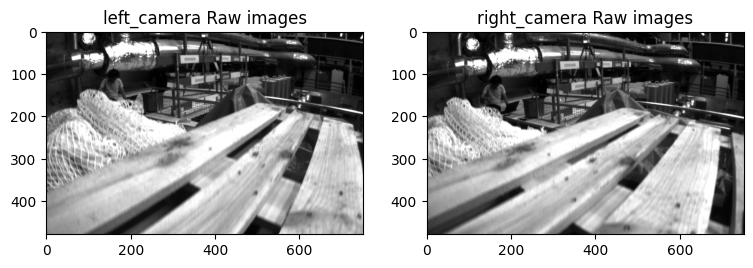

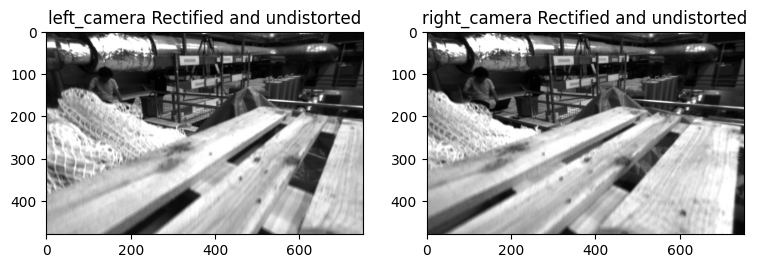

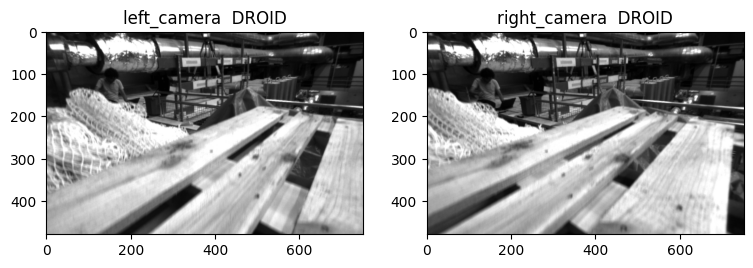

In [150]:
number = 10
map_r = cv.initUndistortRectifyMap(cam_r['k'], cam_r['d'], R_r, P_r[:3, :3], (752, 480), cv.CV_32F)
map_l = cv.initUndistortRectifyMap(cam_l['k'], cam_l['d'], R_l, P_l[:3, :3], (752, 480), cv.CV_32F)

map_r_droid = cv.initUndistortRectifyMap(cam_r['k'], cam_r['d'], cam_r['R'], cam_r['P'][:3, :3], (752, 480), cv.CV_32F)
map_l_droid = cv.initUndistortRectifyMap(cam_l['k'], cam_l['d'], cam_l['R'], cam_l['P'][:3, :3], (752, 480), cv.CV_32F)

image_paths_l = [f for f in Path(IMG_PATH).joinpath("cam0/data").iterdir() if f.is_file()]
image_paths_r = [f for f in Path(IMG_PATH).joinpath("cam1/data").iterdir() if f.is_file()]
image_paths_l = sorted(image_paths_l)
image_paths_r = sorted(image_paths_r)
print(f' image path left camera :  \n {image_paths_l[:2]}',sep='\n')
print(f' image path right camera :  \n {image_paths_r[:2]}',sep='\n')
# display images
img_l = cv.imread(str(image_paths_l[number]), cv.IMREAD_COLOR)
img_r = cv.imread(str(image_paths_r[number]), cv.IMREAD_COLOR)

def show_stereo_images(img_l: np.ndarray, img_r: np.ndarray, title: str = ""):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 9))
    ax[0].imshow(img_l, cmap='gray')
    ax[0].set_title("left_camera " + title)
    ax[1].imshow(img_r, cmap ='gray',)
    ax[1].set_title("right_camera " + title)
print(img_l.shape)
show_stereo_images(img_l=img_l, img_r=img_r, title="Raw images")

# rectified
img_l_remap = cv.remap(img_l, map_l[0], map_l[1], interpolation=cv.INTER_LINEAR)
img_r_remap = cv.remap(img_r, map_r[0], map_r[1], interpolation=cv.INTER_LINEAR)
print(img_l_remap.shape)
show_stereo_images(img_l=img_l_remap, img_r=img_r_remap, title="Rectified and undistorted")


img_l_droid = cv.remap(img_l, map_l_droid[0], map_l_droid[1], interpolation=cv.INTER_LINEAR)
img_r_droid = cv.remap(img_r, map_r_droid[0], map_r_droid[1], interpolation=cv.INTER_LINEAR)
show_stereo_images(img_l_droid, img_r_droid, ' DROID')

shape of single image : (480, 752, 3)
shape of images after stacking: (2, 480, 752, 3)
shape of images after h stacking: (480, 1504, 3)
shape of images after v stacking: (960, 752, 3)
torch.Size([2, 480, 752, 3])
torch.Size([2, 3, 480, 752])
image shape = (752, 480)
images[0] shape = torch.Size([320, 512, 3])


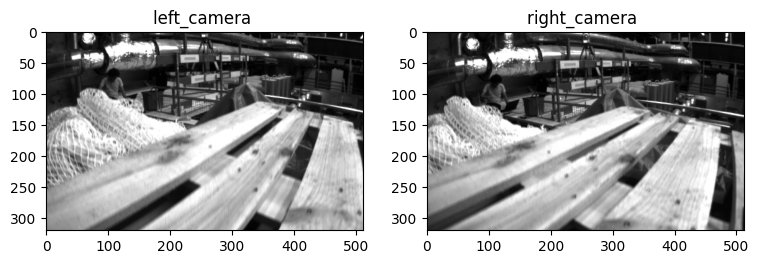

In [151]:
# conversion to torch
# stack basics: https://stackoverflow.com/questions/61688882/how-is-numpy-stack-different-from-numpy-v-stack-and-h-stack
print(f'shape of single image : {img_l.shape}')
images = np.stack([img_l, img_r], 0)
images_h = np.hstack([img_l, img_r])
images_v = np.vstack([img_l, img_r])
print(f'shape of images after stacking: {images.shape}')
print(f'shape of images after h stacking: {images_h.shape}')
print(f'shape of images after v stacking: {images_v.shape}')
images = torch.from_numpy(images)
print(images.shape)
# bring color to the front and geometric array location of pixel to the back. 
images = images.permute(0, 3, 1 ,2)
print(images.shape)
import torch.nn.functional as F
image_size=[320, 512]
print(f'image shape = {image_shape}')
images = F.interpolate(images, image_size, mode='bilinear', align_corners=False)
print(f'images[0] shape = {images[0].permute(1, 2, 0).shape}')
show_stereo_images(images[0].permute(1, 2, 0).numpy(), images[1].permute(1, 2, 0).numpy())

# After resizing the pixel sizes of the new canvas has changed, so 
# the intrinsic parameters also change as they are expressed in the 
# pixel size of the image. 
# ratio along y direction is the ratio of rows as per opencv coordinate axes. 
ratio_columns_fi = 320/480
# ratio along x direction is the ratio of columns as per opencv coordinate axes
ratio_rows_fi = 512/752

K = cam_l['k']
# this needs to be taken care for unproportional resizing on both sides.
# Generally the ratio is same on both axes, so this detail is hidden. 
# number of columns proportional to cx, fx
fx = K[0, 0]*ratio_columns_fi
cx = K[0, 2]*ratio_columns_fi
# number of rows proportional to cy, fy
fy = K[1, 1]*ratio_rows_fi
cy = K[1, 2]*ratio_rows_fi

# Analysis:
1. Rectification of two stereo images is done by computing the left camera and right camera transformations. 
2. In opencv, left camera is the first camera - camera 1, right camera is the camera 2, 
3. In stereorectify function in opencv, the R matrix is R_21 - rotation of left camera with respect to right camera = R_lr.T , t_21 = translation of camera 1 in camera 2 frame = -t_lr. We are trying to convert the 3D point - X_l seen in left camera frame to right camera frame. 
4. When images are resized, one need to take care of the intrinsic parameters because they change because of the change in pixel sizes.
5. The change in fx and cx is impacted by the number of columns in the image as x axis is along that direction in the image. fx is proporational to the number of pixels in the column direction.
6. Similary a change in fy and cy is impacted by the number of row in the image. 
